In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from adjustText import adjust_text
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau
import numpy as np
import seaborn as sns
from matplotlib import gridspec
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch

def split_metric_resolution(col_name):
    """
    Splits column names like '3rd_w_Peak_5m' into ('3rd_w_Peak', '5m').
    Assumes resolution is always the last underscore-suffix (e.g., '_5m').
    """
    parts = col_name.rsplit('_', 1)  # Split only on the last underscore
    if len(parts) == 2 and parts[1] in ['5m', '30m']:
        return parts[0], parts[1]
    else:
        return col_name, None  # No valid resolution suffix found
    
def compute_metric_sensitivity(df, continuous_metrics, categorical_metrics, resolutions=["DMC_10"]):
    rows = []

    for res in resolutions:
        for metric in continuous_metrics + categorical_metrics:
            ref_col = f"{metric}"
            comp_col = f"{metric}_{res}"
            if ref_col not in df.columns or comp_col not in df.columns:
                continue

            x_vals = df[ref_col]
            y_vals = df[comp_col]
            valid = x_vals.notna() & y_vals.notna()
            x = x_vals[valid]
            y = y_vals[valid]

            if len(x) < 2:
                continue

            is_continuous = metric in continuous_metrics
            if is_continuous:
                rank_corr, _ = spearmanr(x, y)
#                 val_diff = np.mean(np.abs(y - x))  # MAD
                # val_diff = np.median(np.abs((y - x) / np.where(x == 0, np.nan, x)) * 100)
                val_diff = 100 * np.mean(np.abs(y - x) / ((np.abs(x) + np.abs(y)) / 2))
            else:
                rank_corr, _ = kendalltau(x, y)
                observed_diff = np.mean(x != y) * 100  # raw % different
                observed_diff = observed_diff*100
                # Option A: Normalize based on number of classes in 5-min data
                n_classes = x.nunique()
                if n_classes > 1:
                    max_diff = (1 - 1 / n_classes) * 100  # convert to percent
                    val_diff = observed_diff / max_diff  # normalized disagreement
                else:
                    val_diff = 0  # No disagreement possible if only one class

            spread = gini(y)

            rows.append({
                "metric": metric,
                "resolution": res,
                "type": "continuous" if is_continuous else "categorical",
                "rank_corr": rank_corr,
                "val_diff": val_diff,
                "gini": spread
            })

    return pd.DataFrame(rows)

def gini(array):
    array = np.sort(np.array(array))
    n = len(array)
    if n == 0:
        return np.nan
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)) if np.sum(array) != 0 else 0

def plot_histograms(ax, metric, metric_type_df, resolutions, log_scale_metrics):
    for res in resolutions:
        col_name = f"{metric}{res}"
        this_type = metric_type_df[metric_type_df['metric']==metric]['type_2'].iloc[0]
        color_map = type_color_map[this_type]
        values = transformed_minmax_scaled[col_name].dropna()
        
        # Use log bins for specified metrics
        if metric in log_scale_metrics:
            values = values[values > 0]  # Avoid log of 0 or negative
            if len(values) > 0:
                bins = 50 # np.logspace(np.log10(values.min()), np.log10(values.max()), 10)
                ax.set_xscale("log")
                # Disable scientific notation on x-axis
                formatter = ScalarFormatter()
                formatter.set_scientific(False)
                formatter.set_useOffset(False)
                ax.xaxis.set_major_formatter(formatter)
            else:
                continue  # Skip empty or non-positive
        else:
            bins = 20
        
        if col_name in transformed_minmax_scaled.columns:
            if col_name =='mean_intensity':
                ax.set_yscale("log")
            sns.histplot(
                values,
                bins=bins,
                kde=False,
                ax=ax,
                color=color_map[resolutions.index(res)],
                label=res,
                element='step',
                stat='density',
                fill=True,
                alpha=0.5,
            )
    ax.set_title(metric, fontsize=16)
    ax.tick_params(axis='both', labelsize=10)
    ax.grid(True)
    
def spaced_colors_from_cmap(cmap_name, values=[0.8], add_grey=False):
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(v)[:3] for v in values]  # RGB only
    if add_grey:
        grey = (0.6, 0.6, 0.6)  # or (0.5, 0.5, 0.5) for slightly darker grey
        colors = [grey] + colors
    return colors    

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from adjustText import adjust_text
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau
import numpy as np
import seaborn as sns

def scatter_without_labels(ax, data, this_metric):
    for _, row in data.iterrows():
        metric_type = row["type_2"]
        resolution = row["resolution"]
        color = type_color_map[metric_type][resolution_index[resolution]]
        ax.scatter(row["rank_corr"], row["val_diff"], color=color, edgecolor='black',
                   marker='o', s=350, alpha=1)
    ax.set_title(this_metric, fontsize=20)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.set_xlabel("Spearman’s ρ", fontsize=15)
    ax.set_ylabel("MAD from 5m", fontsize=15)
    
    # Highlight box
    x_min, x_max = 0.9, 1.001
    y_min, y_max = 0, 0.2
    
    ax.tick_params(axis='both', which='major', labelsize=15)
#     rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
#                              linewidth=3, edgecolor='black', facecolor='none', linestyle='--')
#     ax.add_patch(rect)   
    
# Scatter function
def scatter_without_labels_cat(ax, data, this_metric):
    for _, row in data.iterrows():
        metric_type = row["type"]
        resolution = row["resolution"]
        color = type_color_map[metric_type][resolution_index[resolution]]
        ax.scatter(row["rank_corr"], row["val_diff"], color=color, edgecolor='black',
                   marker='o', s=350, alpha=1)
    ax.set_title(this_metric, fontsize=20)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.set_xlabel("Kendall’s τ", fontsize=15)
    ax.set_ylabel("% Different from 5m", fontsize=15)
    ax.set_ylim(0,70)
    x_min, x_max = 0.8, 1.001  
    y_min, y_max = 0, 10  
    ax.tick_params(axis='both', which='major', labelsize=15)
#     rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
#                              linewidth=3, edgecolor='black', facecolor='none', linestyle='--')
#     ax.add_patch(rect)


def split_metric_resolution(col_name):
    """
    Splits column names like '3rd_w_Peak_5m' into ('3rd_w_Peak', '5m').
    Assumes resolution is always the last underscore-suffix (e.g., '_5m').
    """
    parts = col_name.rsplit('_', 1)  # Split only on the last underscore
    if len(parts) == 2 and parts[1] in ['5m', '30m']:
        return parts[0], parts[1]
    else:
        return col_name, None  # No valid resolution suffix found
    

def gini(array):
    array = np.sort(np.array(array))
    n = len(array)
    if n == 0:
        return np.nan
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)) if np.sum(array) != 0 else 0


In [3]:
# First: Create the mapping for continuous metrics
metric_list = ['frac_q3_wi', 'peak_mean_ratio', 'cv', 'frac_q1_wi', 'time_kurtosis', 'Mean Intensity HIZ',
               '% rain HIZ', 'frac_q2_wi', 'event_dry_ratio', 'lorentz_asymetry', 'm5_wi', 'D50', 'm1',
               'Event Loading', 'time_to_peak', 'asymm_d', 'centre_gravity', 'max_intensity', 'm3_wi',
               'kurtosis', 'skewp', 'I30', 'peak_position_ratio', 'std', 'PCI', 'time_skewness', 'm1_wi',
               'mean_intensity', 'intermittency', 'T75', 'relative_amp', 'NRMSE_P', 'm2_wi', '% time LIZ',
               'm4_wi', 'T25', 'm2', 'skewness', '% time HIZ', 'centre_gravity_interpolated', 'frac_q4_wi',
               'gini', 'TCI']

type_2_list = ['Asymmetry', 'Peakiness', 'Peakiness', 'Asymmetry', 'Asymmetry', 'Peakiness', 'Concentration',
               'Asymmetry', 'Intermittency', 'Concentration', 'Asymmetry', 'Asymmetry', 'Asymmetry', 'Asymmetry',
               'Asymmetry', 'Asymmetry', 'Asymmetry', 'Peakiness', 'Asymmetry', 'Peakiness', 'Asymmetry', 'Peakiness',
               'Asymmetry', 'Peakiness', 'Concentration', 'Asymmetry', 'Asymmetry', 'Peakiness', 'Intermittency',
               'Asymmetry', 'Peakiness', 'Concentration', 'Peakiness', 'Concentration', 'Asymmetry', 'Asymmetry',
               'Peakiness', 'Peakiness', 'Concentration', 'Asymmetry', 'Concentration', 'Concentration', 'Concentration']

type_color_map = {
    'Asymmetry': spaced_colors_from_cmap("Blues", add_grey=True),
    'Peakiness': spaced_colors_from_cmap("Reds", add_grey=True),
    'Concentration': spaced_colors_from_cmap("Greens", add_grey=True),
    'Intermittency': spaced_colors_from_cmap("Purples", add_grey=True),
    'Categorical': spaced_colors_from_cmap("Oranges", add_grey=True),}

resolution_index = {'DMC_10': 2}

# Map type_2 to metrics
type_2_mapping = dict(zip(metric_list, type_2_list))

resolutions = ['', '_DMC_10']

In [4]:
# transformed_minmax_scaled = pd.read_csv("../MinMaxScaledCollectively_Raw_vs_DMC10.csv")
transformed_minmax_scaled = pd.read_csv("../NotScaled_RawVsDMC.csv")

column_names = transformed_minmax_scaled.columns.str.replace('_log', '')
column_names = column_names.str.replace('_yj', '')
# column_names = column_names.str.replace('_wi', '')
transformed_minmax_scaled.columns = column_names

In [5]:
categorical_metrics = ['3rd_ARR',  '3rd_rcg',  '3rd_w_peak', '4th_w_peak', '5th_w_peak', 'third_ppr', '3rd_w_most', 
                       '4th_w_most', '5th_w_most']
continuous_metrics = [metric for metric in column_names if metric not in categorical_metrics]

In [6]:
metric_base_names = {col.replace(suffix, '') for col in transformed_minmax_scaled.columns  for suffix in ['_DMC_10']  if col.endswith(suffix)}

In [7]:
summary_df = compute_metric_sensitivity(df=transformed_minmax_scaled,
    continuous_metrics=continuous_metrics,
    categorical_metrics=categorical_metrics)
summary_df = summary_df[~summary_df['metric'].isin(['m3', 'm4', 'm5'])]

In [8]:
# Filter the dataframe
filtered_df = summary_df[~summary_df["metric"].isin(['m3', 'm4', 'm5'])].copy()
filtered_df["type_2"] = filtered_df["metric"].map(type_2_mapping)

# Exclude Categorical
filtered_df.fillna('Categorical', inplace=True)

# Sort by type_2 and descending rank_corr
filtered_df = filtered_df.sort_values(
    by=["type_2", "rank_corr"],
    key=lambda col: (
        col.map({'Asymmetry': 0, 'Peakiness': 1, 'Concentration': 2, 'Intermittency': 3})
        if col.name == "type_2" else -col))

In [9]:
# Split intermittency and other types
df_intermittency = filtered_df[filtered_df["type_2"] == "Intermittency"]
df_other = filtered_df[(filtered_df["type_2"] != "Intermittency") & (filtered_df["type"] != "categorical")]
df_categorical = filtered_df[filtered_df["type"] == "categorical"]

In [10]:
# plt.hist(transformed_minmax_scaled['mean_intensity'])
# plt.hist(transformed_minmax_scaled['mean_intensity_DMC_10'])

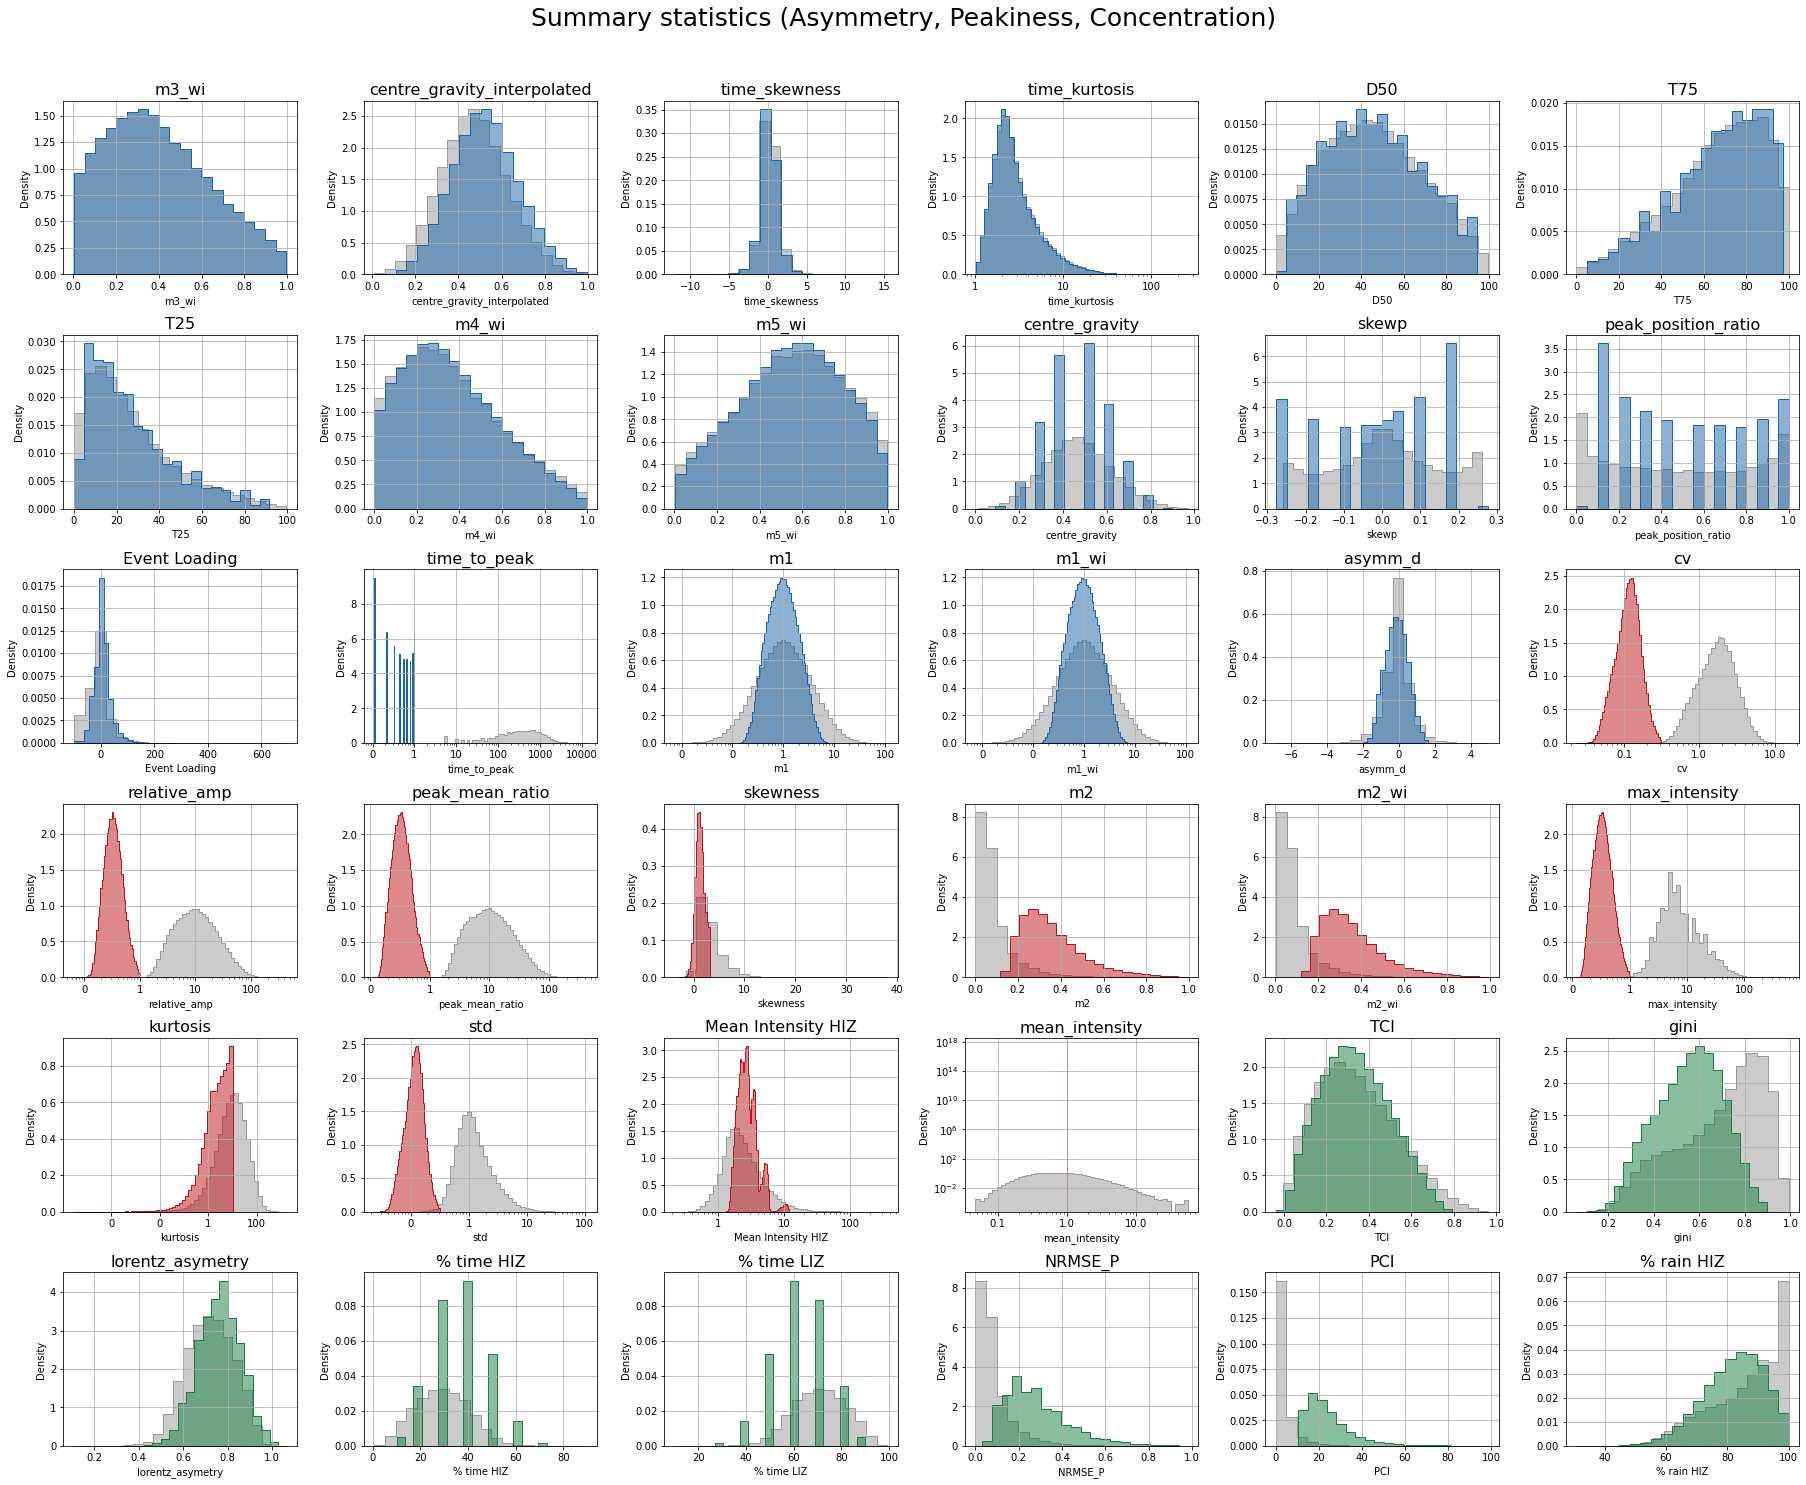

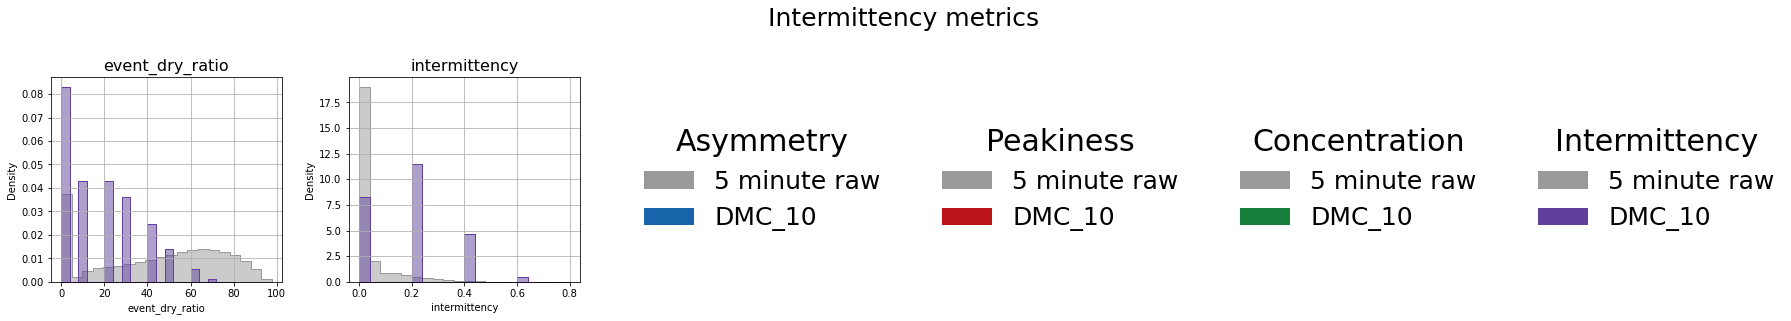

In [11]:
log_scale_metrics = ['mean_intensity', 'time_to_peak', 'std', 'Mean Intensity HIZ', 'm1', 'm1_wi', 'cv', 'time_kurtosis',
                    'max_intensity', 'mean_intensity', 'kurtosis', 'relative_amp', 'peak_mean_ratio']

unique_metrics_main = df_other["metric"].unique()
n_cols_main = 6
n_rows_main = -(-len(unique_metrics_main) // n_cols_main)

fig_main, axs_main = plt.subplots(ncols=n_cols_main, nrows=n_rows_main,
                                  figsize=(4.2 * n_cols_main, 3.5 * n_rows_main),
                                  sharex=False, sharey=False)
axs_main = axs_main.flatten()

# Track max/min values for autoscaled limits
x_min, x_max, y_min, y_max = float('inf'), float('-inf'), float('inf'), float('-inf')

for i, this_metric in enumerate(unique_metrics_main):
    ax = axs_main[i]
    metric_data = df_other[df_other["metric"] == this_metric]
    plot_histograms(ax, this_metric, metric_data, resolutions, log_scale_metrics)

    # Update global x/y limits
    x_vals = metric_data["rank_corr"]
    y_vals = metric_data["val_diff"]
    if not x_vals.empty and not y_vals.empty:
        x_min = min(x_min, x_vals.min())
        x_max = max(x_max, x_vals.max())
        y_min = min(y_min, y_vals.min())
        y_max = max(y_max, y_vals.max())

for ax in axs_main[len(unique_metrics_main):]:
    ax.axis('off')

fig_main.suptitle("Summary statistics (Asymmetry, Peakiness, Concentration)", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig_main.savefig("Figures/histograms_main_DMC10.png", dpi=300, facecolor='white')


# --- PLOT 2: Intermittency Figure ---
if not df_intermittency.empty:
    unique_metrics_int = df_intermittency["metric"].unique()
    n_cols_int = 6
    n_rows_int = -(-len(unique_metrics_int) // n_cols_int)

    fig_int, axs_int = plt.subplots(ncols=n_cols_int, nrows=n_rows_int,
                                    figsize=(4.2 * n_cols_int, 4.5 * n_rows_int),
                                    sharex=False, sharey=False)
    axs_int = axs_int.flatten()

    # Plot each metric
    for i, this_metric in enumerate(unique_metrics_int):
        ax = axs_int[i]
        metric_data = df_intermittency[df_intermittency["metric"] == this_metric]
        plot_histograms(ax, this_metric, metric_data, resolutions, log_scale_metrics)

    legend_types = list(type_color_map.keys())
    legend_axes_start = len(unique_metrics_int)  # first free subplot
    
    labels = ['5 minute raw', 'DMC_10']
    
    for i, metric_type in enumerate(legend_types):
        idx = legend_axes_start + i
        if idx < len(axs_int):
            ax_legend = axs_int[idx]
            ax_legend.axis('off')
            colors = type_color_map[metric_type]
            patches = [Patch(facecolor=colors[j], label=labels[j]) for j in range(len(resolutions))]
            ax_legend.legend(handles=patches, title=metric_type, loc='center', frameon=False, ncol=1, handlelength=2,
                             fontsize=25, title_fontsize =30)

    # Turn off any remaining unused axes after legend
    for ax in axs_int[legend_axes_start + len(legend_types):]:
        ax.axis('off')

    fig_int.suptitle("Intermittency metrics", fontsize=25)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    fig_int.savefig("Figures/histograms_intermittency_DMC10.png", dpi=300, facecolor='white')

In [12]:
# --- Extract all metrics present in transformed_minmax_scaled ---
all_metric_names = filtered_df['metric'].unique()

# --- Assign types ---
metric_type_df = (
    pd.DataFrame({'metric': all_metric_names})
    .assign(type_2=lambda df: df['metric'].map(type_2_mapping)))

metric_type_df.fillna('Categorical', inplace=True)

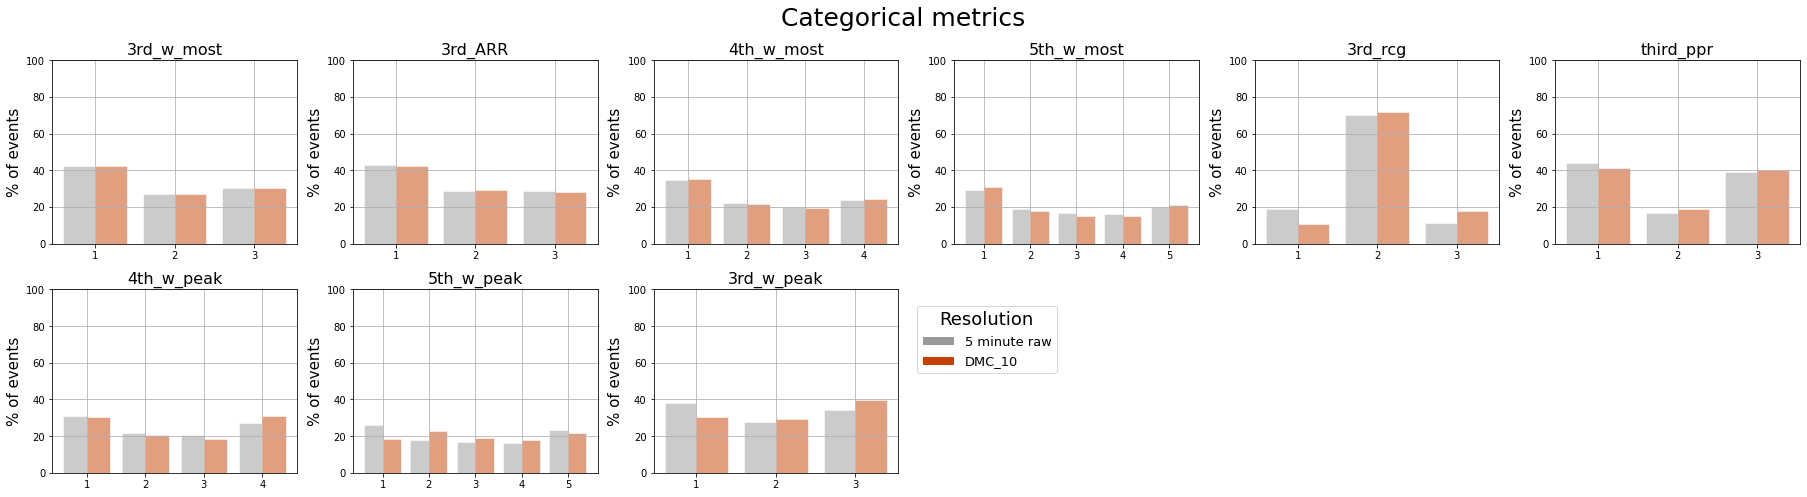

In [13]:
def plot_grouped_categorical(ax, metric, df, metric_type_df, type_color_map):
    # 1. build normalized counts per category per resolution
    vc = {
        res: df[f"{metric}{res}"].value_counts(normalize=True)
        for res in resolutions
    }
    vc_df = pd.DataFrame(vc).fillna(0)        # index = category values
    vc_df = vc_df.sort_index()               # ensure logical order of categories
    categories = vc_df.index.tolist()

    # Adjust x-axis labels if numeric categories (0-indexed integers)
    categories = range(0,len(categories))
    x_labels = categories  # use original labels if not numeric
    x_labels = [str(int(cat) + 1) for cat in categories]
        
    # 2. bar positions
    x = np.arange(len(categories))
    n = len(resolutions)
    total_width = 0.8
    width = total_width / n

    # 3. fetch colors for this metric’s type
    palette = type_color_map['Categorical']

    # 4. draw each resolution’s bars (convert to percentage)
    for i, res in enumerate(resolutions):
        heights = vc_df[res].values * 100  # convert to percent
        offset = (i - (n-1)/2) * width
        ax.bar(
            x + offset,
            heights,
            width=width,
            label=res,
            color=palette[i],
            edgecolor='white',
            alpha=0.5
        )

    # 5. formatting
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=0, fontsize=10)
    ax.set_ylim(0, 100)
    ax.set_ylabel("% of events", fontsize=15)
    ax.set_title(metric, fontsize=16)
#     ax.grid(axis='y', linestyle=':', alpha=0.6)
    ax.grid(True)


# --- now make your grid of small multiples ---
unique_metrics =df_categorical['metric'].unique().tolist()
n_cols = 6
n_rows = -(-len(unique_metrics) // n_cols)
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(4.2 * n_cols, 3.5 * n_rows), sharex=False, sharey=False)
axs = axs.flatten()

for i, metric in enumerate(unique_metrics):
    plot_grouped_categorical(
        axs[i],
        metric,
        transformed_minmax_scaled,
        metric_type_df,
        type_color_map
    )

# turn off any unused axes
for ax in axs[len(unique_metrics):]:
    ax.axis('off')

from matplotlib.patches import Patch

# Create custom legend handles using the palette
palette = type_color_map['Categorical']
legend_handles = [
    Patch(facecolor=palette[i], edgecolor='white', label=res)
    for i, res in enumerate(labels)]

fig.legend(
    handles=legend_handles,
    labels=labels,
    title="Resolution",
    title_fontsize=18,    # larger title
    fontsize=13,          # larger labels
    bbox_to_anchor=(0.5, 0.32),
    loc='center left',
    borderaxespad=1.0,
    labelspacing=0.5,     # space between labels
    handlelength=2.5,     # length of color boxes
    handletextpad=0.8     # space between box and text
)

fig.suptitle("Categorical metrics", fontsize=25)
plt.tight_layout()
plt.show()
fig.savefig("Figures/grouped_categorical_metrics_DMC10.png", dpi=300, facecolor='white')